# Synopsis
Author: Kaushalya Samarasekera
Date: November 2022

In this notebook I first perform an exploratory data analysis on the *[Short-term electricity load forecasting (Panama case study)](https://data.mendeley.com/datasets/byx7sztj59/1)* dataset to survey the data quality and distribution of its target variables.

Then the data is passed through a couple of Ensemble methods to derive the best performing model. Firstly a Random Forest regressor is used to form a benchmark followed by a XGBoost regressor in search for a model with higher accuracy. During this process a number of model parameters are tuned and evaluated repetitively to minimize the prediction errors.

Finally, the best performing model is exported to a bentoml model to use in `predict.py` to serve through a web api.

# Imports

In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import json

from shared_func import train_gb_model

# Exploratory Data Analysis (EDA)

In [3]:
# loading the complete dataset
data_file = 'data/continuous_dataset.csv'
df = pd.read_csv(data_file)

In [4]:
# This dataset contains the feature variables and dependent variable datetime.
df[:100]

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-07 00:00:00,979.6728,24.899164,0.016859,0.011879,20.375056,22.680414,0.016531,0.016052,9.519345,21.953851,0.015768,0.098938,6.345989,0,0,0
96,2015-01-07 01:00:00,940.4568,24.863245,0.016943,0.015156,20.156554,22.425745,0.016386,0.015404,10.078217,21.761682,0.015573,0.100281,6.593827,0,0,0
97,2015-01-07 02:00:00,908.5931,24.865564,0.017057,0.018219,20.108580,22.248376,0.016226,0.012043,10.661059,21.568689,0.015363,0.100769,6.843872,0,0,0
98,2015-01-07 03:00:00,886.4675,24.900903,0.017172,0.018593,20.347526,22.057153,0.016035,0.007059,11.029632,21.400903,0.015165,0.102234,7.152504,0,0,0


In [5]:
df.describe()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


According to the *describe* output, this is a clean dataset. There are no data corrections required. Below I'm performing some verifications to confirm this.

In [6]:
# Making columns lower case for better readability.
df.columns = df.columns.str.lower()
df.columns

Index(['datetime', 'nat_demand', 't2m_toc', 'qv2m_toc', 'tql_toc', 'w2m_toc',
       't2m_san', 'qv2m_san', 'tql_san', 'w2m_san', 't2m_dav', 'qv2m_dav',
       'tql_dav', 'w2m_dav', 'holiday_id', 'holiday', 'school'],
      dtype='object')

In [7]:
# Checking if there are missing values in any of the variables. None found.
df.isna().sum()

datetime      0
nat_demand    0
t2m_toc       0
qv2m_toc      0
tql_toc       0
w2m_toc       0
t2m_san       0
qv2m_san      0
tql_san       0
w2m_san       0
t2m_dav       0
qv2m_dav      0
tql_dav       0
w2m_dav       0
holiday_id    0
holiday       0
school        0
dtype: int64

In [8]:
# Check the data types of the variables. Looks like datatime is a string and all other variables are numeric (int or float).
df.dtypes

datetime       object
nat_demand    float64
t2m_toc       float64
qv2m_toc      float64
tql_toc       float64
w2m_toc       float64
t2m_san       float64
qv2m_san      float64
tql_san       float64
w2m_san       float64
t2m_dav       float64
qv2m_dav      float64
tql_dav       float64
w2m_dav       float64
holiday_id      int64
holiday         int64
school          int64
dtype: object

In [9]:
# Checking if variable `school` has non-boolean values
df.school.value_counts()

1    34969
0    13079
Name: school, dtype: int64

In [10]:
# Checking if variable `holiday` has non-boolean values
df.holiday.value_counts()

0    45024
1     3024
Name: holiday, dtype: int64

In [11]:
# Checking if 0's in `holiday_id` matches the number of holidays based on `holiday`.
assert df.holiday_id.value_counts()[0] == df.holiday.value_counts()[0]

As observed above, `datetime` is a string variable. I'm converting this to a python `datetime` datatype and spliting year, month, day, hour to seperate (new) variables for the following reasons:
* For regression model training the input features needs to be in numerical form. Splitting the datetime values to individual components meets this prerequisite.
* Having the datetime string value converted to datetime type will work better when comes to date-time based filtering and plotting the predictions/forecast over time.

In [12]:
# Creating a new variable called `dt` of type pd.datetime by converting the values from `df.datetime`.
df['dt'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Checking if there are datetime conversion errors.
assert df.dt.isnull().sum() == 0

# delete datetime from the dataframe as dt supersedes it now.
del df['datetime']

In [13]:
# splitting year, month, day and hour to new variables
df['dt_year'] = df['dt'].dt.year
df['dt_month'] = df['dt'].dt.month
df['dt_day'] = df['dt'].dt.day
df['dt_hour'] = df['dt'].dt.hour

# No need to separate minute and second values as they are always 0. Verified and confirmed.
# df['dt_minute'] = df.datetime.dt.minute
# df['dt_second'] = df.datetime.dt.second

In [14]:
# Look at first 5 of 10000th record for a visual check to confirm that they've been split correctly (from a semantic viewpoint).
# Programmatic check was done earlier by checking for conversion errors. See above.
df.filter(regex='dt.*')[::10000].head()

,dt,dt_year,dt_month,dt_day,dt_hour
0,2015-01-03 01:00:00,2015,1,3,1
10000,2016-02-23 17:00:00,2016,2,23,17
20000,2017-04-15 09:00:00,2017,4,15,9
30000,2018-06-06 01:00:00,2018,6,6,1
40000,2019-07-27 17:00:00,2019,7,27,17


Here is the distribution of the target variable `nat_demand` (short for National Electricity Demand). The target variables shows a normal/Gaussian distribution. I plotted this solely for data exploratory purposes. It's important to note that having a normal distribution is [not a must](https://data.library.virginia.edu/normality-assumption/#:~:text=No%2C%20you%20don't%20have,or%20an%20outcome%20(DV).) for regression based predictions. What's important to ensure is that the *prediction error* is normally distributed. A plot for the prediction error distribution can be found in the section where the best performing model is derived (towards the end of the notebook).

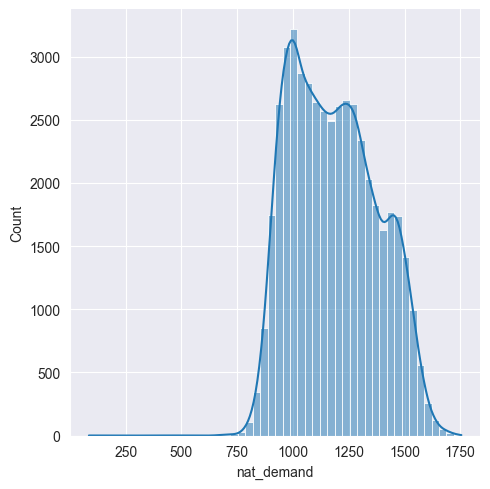

In [15]:
sns.displot(df.nat_demand, bins=50, kde=True)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

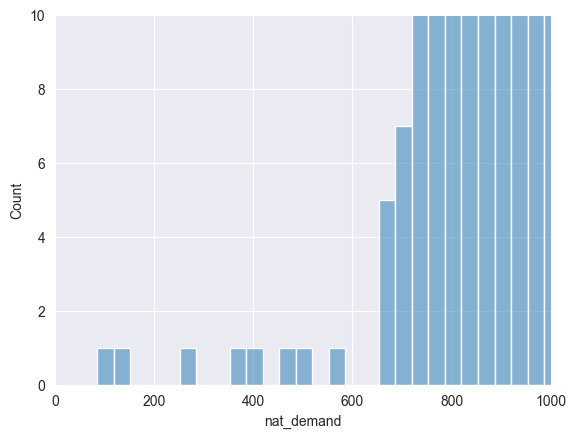

In [16]:
# Focusing on the outliers on the left for a closer look. This is the reason the distribution is not centred.
plt.xlim(0, 1000)
plt.ylim(0, 10)
sns.histplot(df.nat_demand, bins=50, alpha=0.5)

In [17]:
# Looks like there are 8 very low demands. This is only a 0.017% of the total records.
# Without these outliers the national demand values are near 'normally' distributed with no long tails.
round(df.nat_demand[df.nat_demand < 600].size / len(df.nat_demand) * 100, 3)

0.017

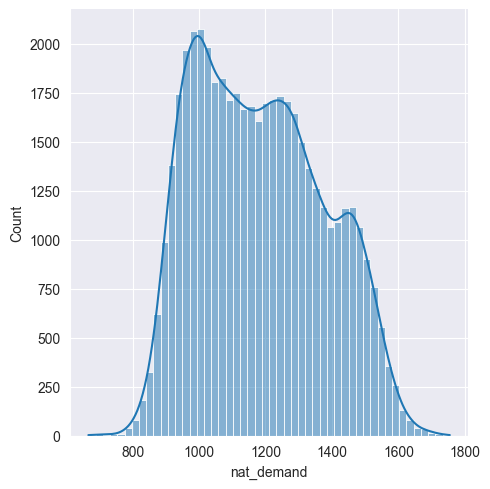

In [18]:
sns.displot(df.nat_demand[df.nat_demand > 600], bins=50, kde=True)

In [19]:
# Splitting the dataset to 80%, 20%, 20% for training, validation, and testing, respectively.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
f'train:val:test split is {(len(df_train), len(df_val), len(df_test))}'

'train:val:test split is (28828, 9610, 9610)'

In [20]:
# Also create a copy of the complete dataframe with order intact to plot actual vs forecast based on the final model.
df_full = df.copy()
f'complete dataset is {len(df_full)}'

'complete dataset is 48048'

In [21]:
# Resetting indices
df_full_train.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_full.reset_index(
    inplace=True)  # not necessary, but done so the for-loop below doesn't fail due to not having an index column.

In [22]:
# Defining the target arrays for each feature datasets
y_full_train = df_full_train.nat_demand
y_train = df_train.nat_demand
y_val = df_val.nat_demand
y_test = df_test.nat_demand
y_full = df_full.nat_demand

In [23]:
# Removing unwanted variables
for c in ['nat_demand', 'dt', 'index']:
    del df_full_train[c]
    del df_train[c]
    del df_val[c]
    del df_test[c]
    del df_full[c]

In [24]:
# Vectorize the features
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

features = dv.get_feature_names_out()

# Initialize dmatrix objects to use later in xgboosting
dm_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dm_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dm_test = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Random Forest

Training a Random Forest Regressor by tuning 3 of its parameters, viz. n_estimators, max_depth and min_samples_leaf, to derive the best (lowest) RMSE score. The resulting RMSE will be set as the baseline. Once the baseline is set, an XGBoost Regressor will be trained and evaluated next to see if we can achieve a model with a better RMSE.

### Benchmark 1
Train a model and measure performance with default `n_estimators`, `max_depth` and `min_samples_leaf` values.

In [24]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=None,
                           min_samples_leaf=1,
                           random_state=1,
                           n_jobs=-1)
model = rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)


#### Feature importance (Gini)

<BarContainer object of 19 artists>

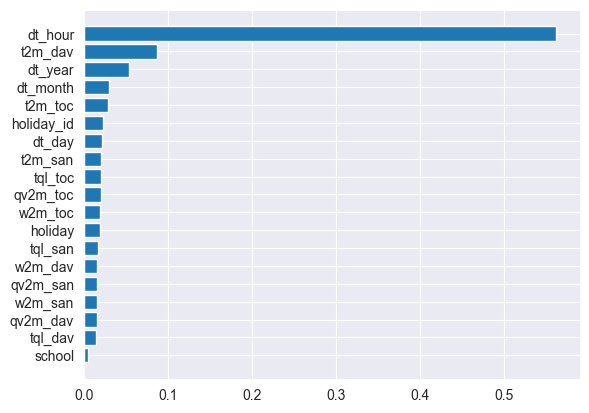

In [25]:
ft_imp = list(zip(rf.feature_importances_, dv.get_feature_names_out()))
df_ft_imp = pd.DataFrame(ft_imp, columns=['score', 'feature']).sort_values(by='score', ascending=True)
plt.barh(df_ft_imp.feature, df_ft_imp.score)

#### Performance

In [26]:
rf_performance = [('rmse', np.sqrt(mean_squared_error(y_val, y_val_pred))),
                  ('mae', mean_absolute_error(y_val, y_val_pred))]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,78.025756
1,mae,53.758384


### Benchmark 2
Training the model with tuned parameters.

#### Tune `n_estimators` and `max_depth`

In [27]:
# Finding the optimal max_depth and n_estimators
scores = []
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, d, rmse, mae))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse', 'mae'])

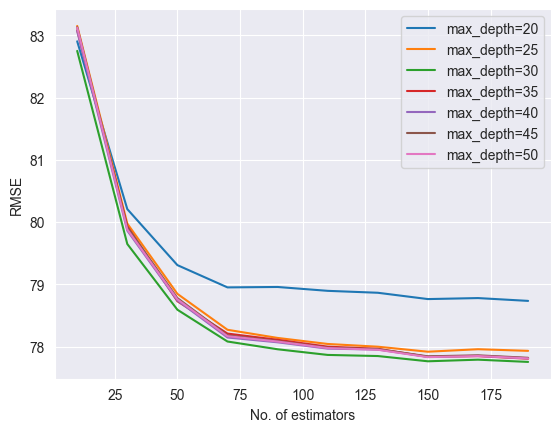

In [29]:
# plt.figure(figsize=(8, 6))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for d in [20, 25, 30, 35, 40, 45, 50]:
    plt.plot(df_scores[df_scores.max_depth == d].n_estimators,
             df_scores[df_scores.max_depth == d].rmse,
             label=f'max_depth={d}')
plt.legend()

#### Tune `min_samples_leaf`

In [30]:
# Based on the above graph, optimal max_depth is 30.
max_depth = 30

# Finding the optimal min_samples_leaf
scores = []
for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=max_depth,
                                   min_samples_leaf=s,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, s, rmse, mae))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'min_samples_leaf', 'rmse', 'mae'])
df_scores

,n_estimators,min_samples_leaf,rmse,mae
0,10,1,82.749170,56.151398
1,30,1,79.647569,54.457571
2,50,1,78.591844,53.994418
3,70,1,78.081145,53.686325
4,90,1,77.956769,53.682695
5,110,1,77.865872,53.710752
6,130,1,77.847921,53.699541
7,150,1,77.763661,53.670636
8,170,1,77.789606,53.669684
9,190,1,77.753469,53.663693


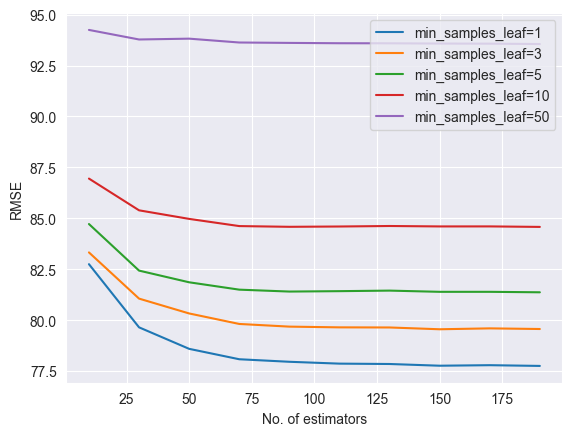

In [32]:
# plt.figure(figsize=(10, 8))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for s in [1, 3, 5, 10, 50]:
    plt.plot(df_scores[df_scores.min_samples_leaf == s].n_estimators,
             df_scores[df_scores.min_samples_leaf == s].rmse,
             label=f'min_samples_leaf={s}')
plt.legend()

In [33]:
n_estimators = 150
max_depth = 30
min_samples_leaf = 1

rf = RandomForestRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

#### Feature importance (Gini)

<BarContainer object of 19 artists>

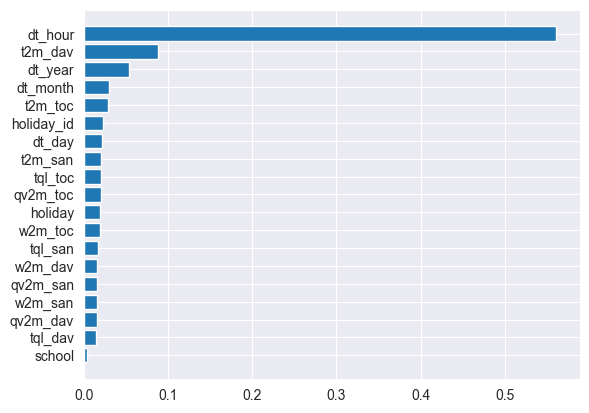

In [34]:
ft_imp = list(zip(rf.feature_importances_, dv.get_feature_names_out()))
df_ft_imp = pd.DataFrame(ft_imp, columns=['score', 'feature']).sort_values(by='score', ascending=True)
plt.barh(df_ft_imp.feature, df_ft_imp.score)

#### Performance

In [35]:
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

rf_performance = [('rmse', rmse),
                  ('mae', mae)]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,77.763661
1,mae,53.670636


**Result:**
Benchmark 2 results is slightly better than Benchmark 1. Therefore, Benchmark 2 will be used as the benchmark for the model performance and will be used for comparison when measuring performance of the gradient boosting models in the next section.

# XGBoost

### Tune `eta`

In [37]:
# def train_gb_model(dm_train,
#                    eta=0.3,
#                    max_depth=6,
#                    min_child_weight=1,
#                    num_boost_round=201,
#                    watchlist=[(dm_train, 'train'), (dm_val, 'val')]):
#     xgb_params = {
#         'eta': eta,
#         'max_depth': max_depth,
#         'min_child_weight': min_child_weight,
#
#         'eval_metric': 'rmse',
#         'objective': 'reg:squarederror',
#         'nthread': -1,
#
#         'seed': 1,
#         'verbosity': 1
#     }
#     evals_result = {}
#     model = xgb.train(params=xgb_params,
#                       dtrain=dm_train,
#                       num_boost_round=num_boost_round,
#                       evals=watchlist,
#                       evals_result=evals_result,
#                       verbose_eval=False)
#
#     columns = ['eta', 'iter', 'train_rmse', 'val_rmse']
#     train_rmse_scores = list(evals_result['train'].values())[0] if watchlist is not None else []
#     val_rmse_scores = list(evals_result['val'].values())[0] if watchlist is not None else []
#
#     df_scores = pd.DataFrame(
#         list(zip([eta] * len(train_rmse_scores),
#                  range(1, len(train_rmse_scores) + 1),
#                  train_rmse_scores,
#                  val_rmse_scores
#                  )), columns=columns)
#     return model, df_scores

In [38]:
scores = pd.DataFrame()
for eta in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 1.0]):
    key = f'eta={eta}'
    _, df_scores = train_gb_model(dm_train,
                                  eta=eta,
                                  num_boost_round=201,
                                  watchlist=[(dm_train, 'train'), (dm_val, 'val')])
    scores = pd.concat([scores, df_scores])

  0%|          | 0/7 [00:00<?, ?it/s]

In [39]:
scores.sort_values(by='val_rmse', ascending=True).reset_index().iloc[::200]

,index,eta,iter,train_rmse,val_rmse
0,199,0.30,200,43.937635,76.946020
200,125,0.40,126,48.167300,78.603832
400,94,0.20,95,66.997543,81.148105
600,101,0.10,102,75.530383,84.889174
800,98,0.05,99,83.367727,89.090841
1000,149,1.00,150,33.623965,95.135644
1200,151,0.01,152,277.224588,278.455859
1400,5,0.01,6,1129.199768,1127.166493


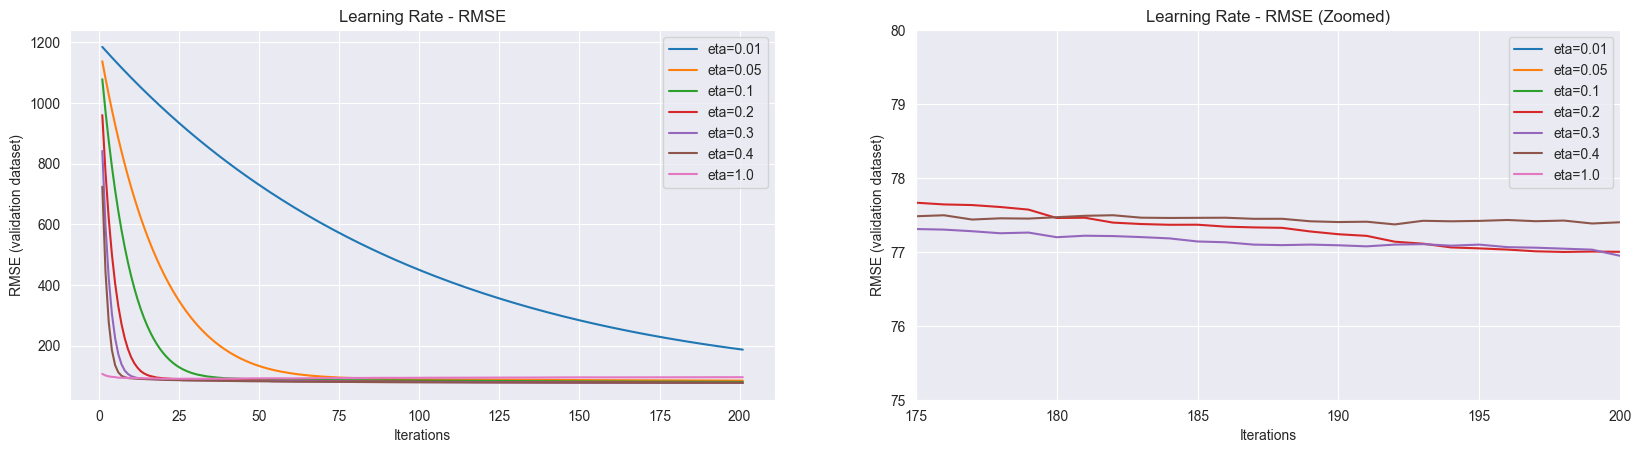

In [40]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Learning Rate - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[0].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[0].legend()

axs[1].set_title('Learning Rate - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([75, 80])
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[1].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[1].legend()

In [28]:
# Base on the above analysis, eta=0.3 gives the best performance as the learning rate.
chosen_eta = 0.3

### Tune `max_depth`

In [42]:
scores = {}
for max_depth in [3, 4, 6, 10, 14, 18]:
    key = f'max_depth={max_depth}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=max_depth,
                                    num_boost_round=201,
                                    watchlist=[(dm_train, 'train'), (dm_val, 'val')])

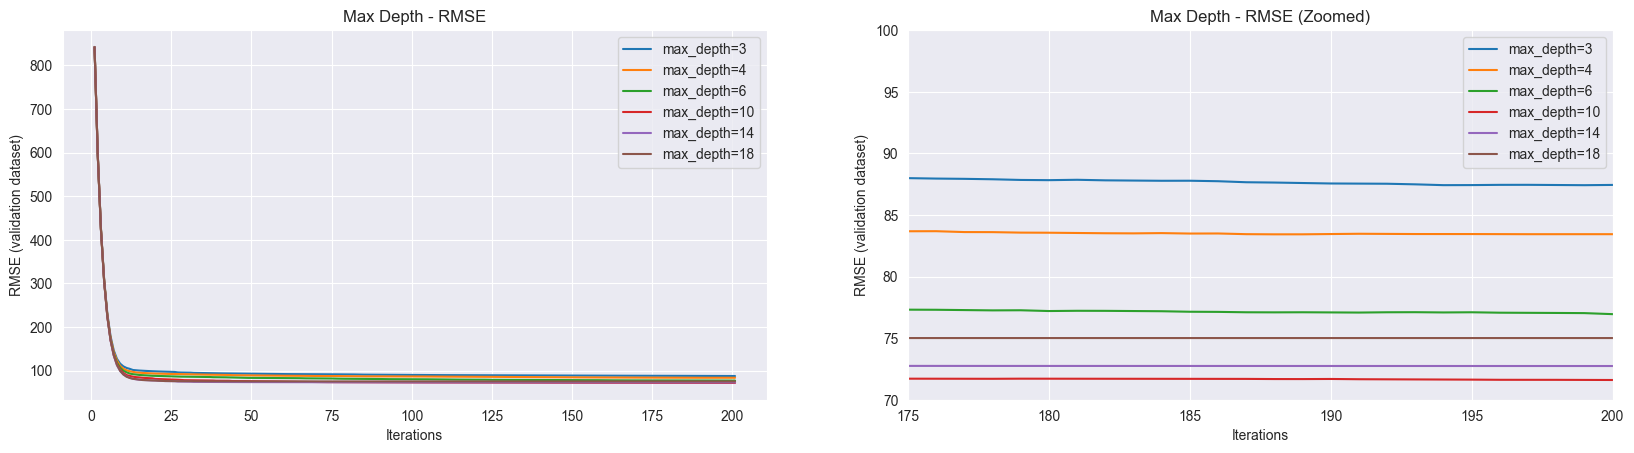

In [43]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Max Depth - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for key, df_scores in scores.items():
    axs[0].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[0].legend()

axs[1].set_title('Max Depth - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 100])
for key, df_scores in scores.items():
    axs[1].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[1].legend()

In [29]:
# The above analysis shows max_depth=10 gies the best performance.
chosen_max_depth = 10

### Tune `min_child_weight`

In [45]:
scores = {}
for min_child_weight in [1, 10, 30, 40]:
    key = f'min_child_weight={min_child_weight}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=chosen_max_depth,
                                    min_child_weight=min_child_weight,
                                    num_boost_round=201,
                                    watchlist=[(dm_train, 'train'), (dm_val, 'val')])

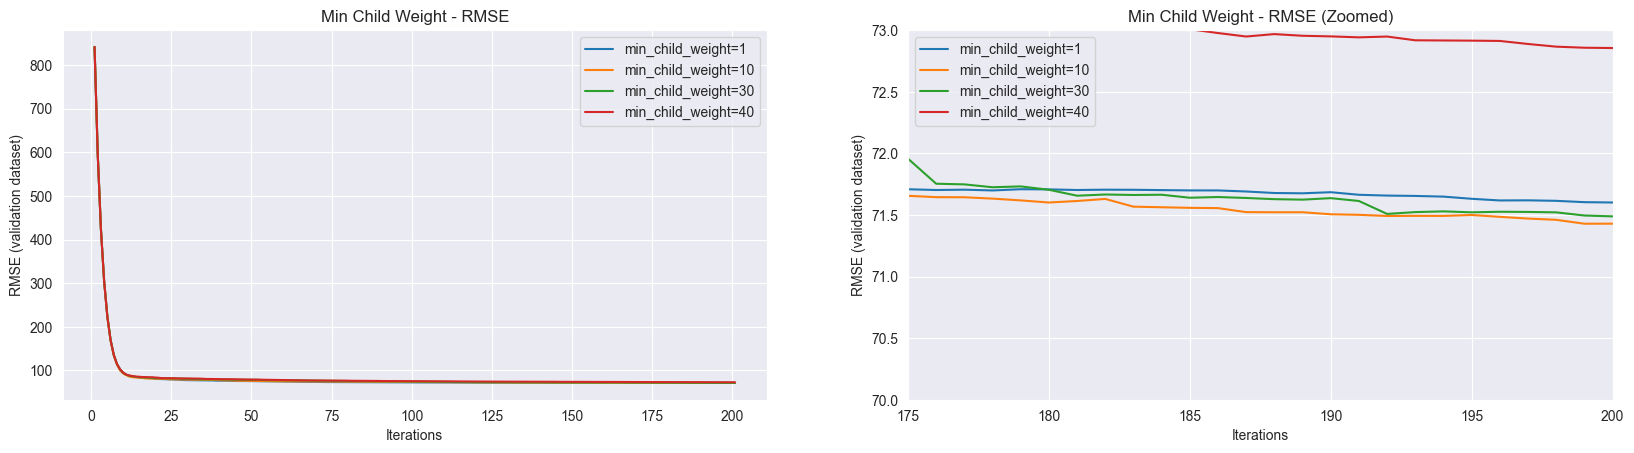

In [46]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Min Child Weight - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[0].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[0].legend()

axs[1].set_title('Min Child Weight - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 73])
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[1].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[1].legend()

In [30]:
# The above analysis shows min_child_weight=30 gives the best performance.
chosen_min_child_weight = 30

### Final GB model and its Performance

In [24]:
# training with full_train and chosen params, df_test as the validation set. Measure the performance.
chosen_eta = 0.3
chosen_max_depth = 10
chosen_min_child_weight = 30

full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
dm_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)

(model, scores) = train_gb_model(dm_train=dm_full_train,
                                 eta=chosen_eta,
                                 max_depth=chosen_max_depth,
                                 min_child_weight=chosen_min_child_weight,
                                 num_boost_round=201,
                                 watchlist=[(dm_full_train, 'train'), (dm_test, 'val')])

gb_rmse = scores.sort_values(by='val_rmse').iloc[0, 3]
f'rmse of xgb model on full_train set = {gb_rmse}'

'rmse of xgb model on full_train set = 65.20070797072874'

<BarContainer object of 19 artists>

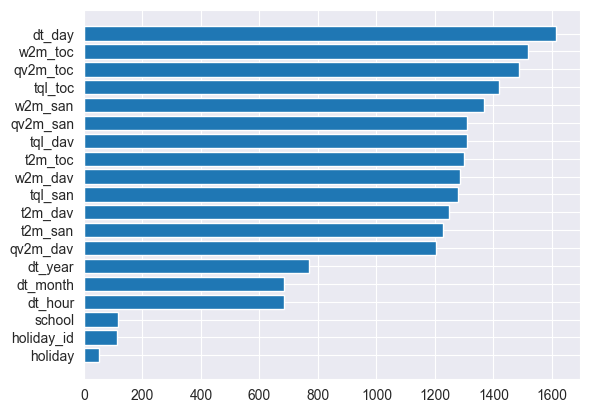

In [25]:
df_ft_imp = pd.DataFrame.from_dict(
    model.get_score(importance_type='weight'), orient='index').sort_values(by=0, ascending=True)
df_ft_imp.columns = ['score']
plt.barh(df_ft_imp.index, df_ft_imp.score)

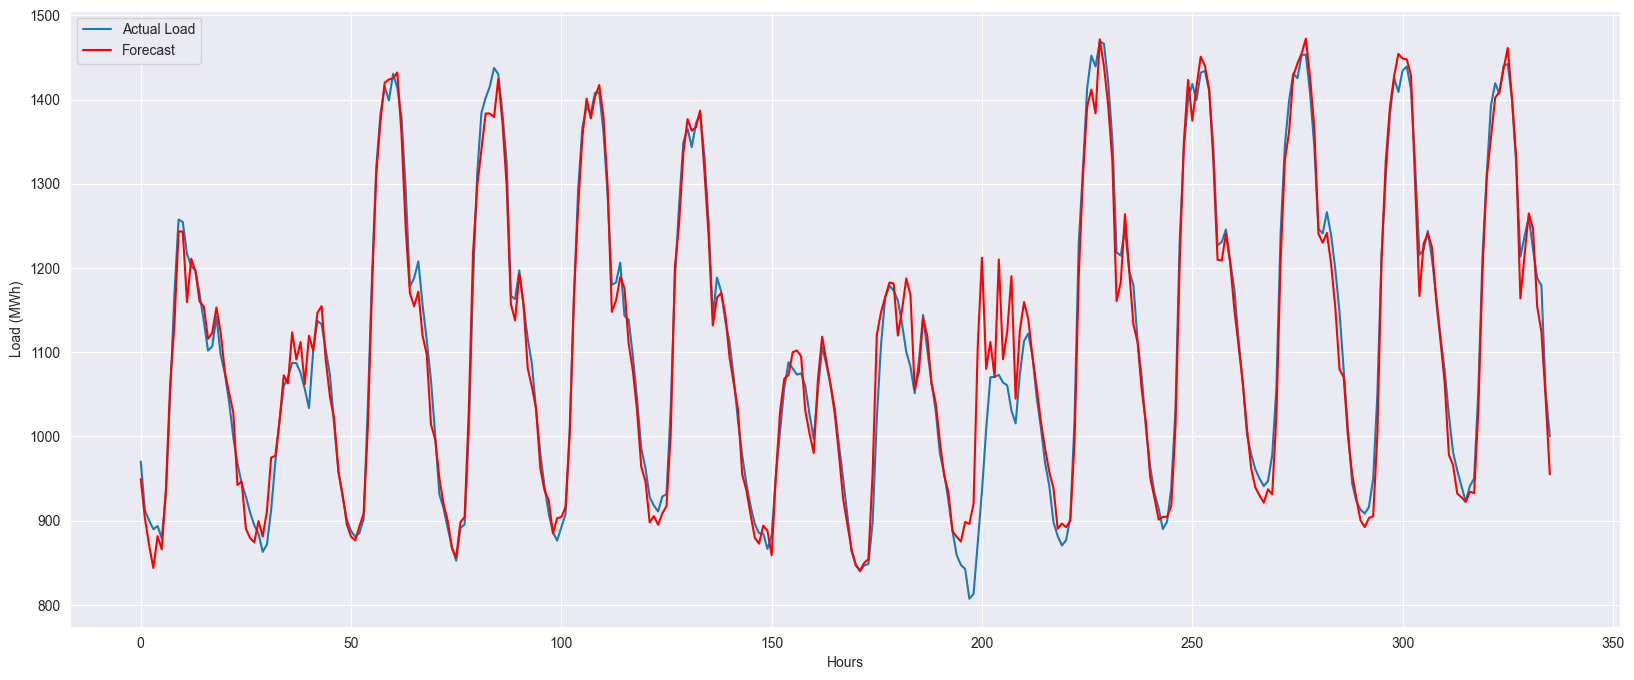

In [26]:
# Plot using the df_full_train and y_full_train to see how closely the forecasted demand tracks against the actual demand.
# Why are we using df_full here? To plot the forecast and actual, we need the data in the correct order. Because the load/demand
# is recorded hourly and continuously. In the other dataframes the data is shuffled therefore not suitable for plotting.
full_dicts = df_full.to_dict(orient='records')
X_full = dv.transform(full_dicts)
dm_full = xgb.DMatrix(X_full, label=y_full, feature_names=features)

y_full_pred = model.predict(dm_full)

plt.figure(figsize=(20, 8))
load_period = 24 * 14
actual = y_full[:load_period]
predict = y_full_pred[:load_period]

plt.plot(actual.index, list(actual), label='Actual Load')
plt.plot(actual.index, list(predict), color='red', label='Forecast')
plt.xlabel('Hours')
plt.ylabel('Load (MWh)')
plt.legend()

Plotting the prediction error distribution. The plot depicts a normal distribution for the prediction error of the best performing model. This confirms the following about the input dataset used for training the model (see [source](https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd)):
* The dependent or independent variables are not too non-normal.
* No outliers exist in the features which disrupt the model prediction.

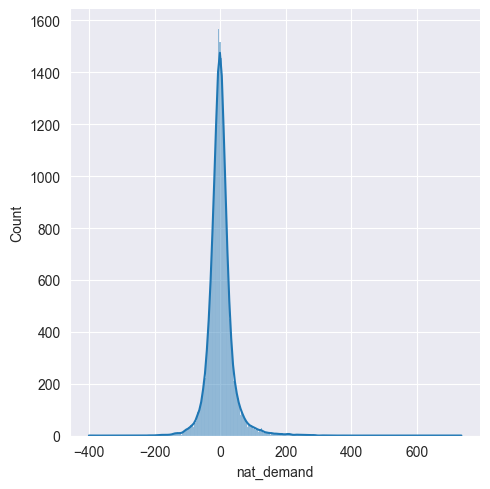

In [42]:
error = y_full_pred - y_full
sns.displot(error, kde=True)

# Export Model
Exporting the model using bentoml to serve as an online service.

In [27]:
import bentoml

# retraining without the feature_names in the dmatrix, as otherwise predict() will fail later in the pipeline.
dm_full_train = xgb.DMatrix(X_full_train, label=y_full_train)
(model, scores) = train_gb_model(dm_train=dm_full_train,
                                 eta=chosen_eta,
                                 max_depth=chosen_max_depth,
                                 min_child_weight=chosen_min_child_weight,
                                 num_boost_round=201,
                                 watchlist=None)
bentoml.xgboost.save_model("load_forecast_model", model,
                           custom_objects={
                               "dictVectorizer": dv
                           },
                           signatures={
                               "predict": {
                                   "batchable": True,
                                   "batch_dim": 0
                               }
                           })

Model(tag="load_forecast_model:yo634rs43wwok6cp", path="/Users/kaushalya/bentoml/models/load_forecast_model/yo634rs43wwok6cp/")

# Export Test Data for the Dashboard
This exports the test dataframe as a json file to feed into the load forecast dashboard. See dashboard.py for the app and/or see the details in the README.md.

A test request payload i.e. `dict(df_test.iloc[0])` for adhoc testing

```json
{
  "t2m_toc": 25.6113220214844,
  "qv2m_toc": 0.01747758,
  "tql_toc": 0.043762207,
  "w2m_toc": 15.885400482402956,
  "t2m_san": 23.8613220214844,
  "qv2m_san": 0.016439982,
  "tql_san": 0.03894043,
  "w2m_san": 6.2321456709303815,
  "t2m_dav": 22.9472595214844,
  "qv2m_dav": 0.01531083,
  "tql_dav": 0.062301636,
  "w2m_dav": 3.6011136954933645,
  "holiday_id": 0.0,
  "holiday": 0.0,
  "school": 0.0,
  "dt_year": 2019.0,
  "dt_month": 1.0,
  "dt_day": 8.0,
  "dt_hour": 20.0
}
```

In [25]:
df_json = df_full[-1100:]
df_json['nat_demand'] = y_full[-1100:]
json_test = df_json.to_json(orient='records')
parsed_json = json.loads(json_test)

/var/folders/3k/wpbmfx3d5_l7cm4gbhbxtnk80000gp/T/ipykernel_16833/1839320458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json['nat_demand'] = y_full[-1100:]


In [26]:
with open("dashboard/test_input.json", 'w') as f_out:
    json.dump(parsed_json, f_out)